In [1]:
#imports

import at3d
import numpy as np
import xarray as xr
from collections import OrderedDict
import pylab as py
np.random.seed(1)

In [2]:
sensors, solvers, rte_grid = at3d.util.load_forward_model('./SimulateRadiancesGeometric.nc')

# Perform some cloud masking using a single fixed threshold based on the observation that 
# everywhere else will be very dark.
sensor_list = []
for sensor in sensors['MSPI']['sensor_list']:
    copied = sensor.copy(deep=True)
    weights = np.zeros(sensor.sizes['nrays'])
    ray_mask =np.zeros(sensor.sizes['nrays'], dtype=int)
    
    ray_mask_pixel = np.zeros(sensor.npixels.size, dtype=int)
    
    # I have not optimized this threshold whatsoever.
    # Feel free to experiment with the cloud mask threshold. 
    # You can compare the observations
    # with a visualization of the initial_state to evaluate the mask.
    # or look at at3d.space_carve.SpaceCarver.project
    ray_mask_pixel[np.where(sensor.I.data > 0)] = 1
    copied['weights'] = ('nrays',sensor.I.data)
    copied['cloud_mask'] = ('nrays', ray_mask_pixel[sensor.pixel_index.data])
    sensor_list.append(copied)

space_carver = at3d.space_carve.SpaceCarver(rte_grid, 3) # 3 means open boundary in both dimensions
carved_volume = space_carver.carve(sensor_list, agreement=(0.0, 1.0), linear_mode=False)

# remove cloud mask values at outer boundaries to prevent interaction with open boundary conditions.
carved_volume.mask[0] = carved_volume.mask[-1] =carved_volume.mask[:,0] =carved_volume.mask[:,-1] = 0.0
        

In [3]:
# make forward_sensors which will hold synthetic measurements from the evaluation of the forward model.
forward_sensors = sensors.make_forward_sensors()

# add an uncertainty model to the observations.
uncertainty = at3d.uncertainties.NullUncertainty('L2',1e10)
sensors.add_uncertainty_model('MSPI', uncertainty)

# prepare all of the static inputs to the solver just copy pasted from forward model
surfaces = OrderedDict()
numerical_parameters = OrderedDict()
sources = OrderedDict()
num_stokes = OrderedDict()
background_optical_scatterers = OrderedDict()
for key in forward_sensors.get_unique_solvers():
    surfaces[key] = solvers[key].surface
    numerical_params = solvers[key].numerical_params
    #numerical_params['num_mu_bins'] = 2
    #numerical_params['num_phi_bins'] = 4
    numerical_parameters[key] = numerical_params
    sources[key] = solvers[key].source
    num_stokes[key] = solvers[key]._nstokes
    background_optical_scatterers[key] = {'rayleigh': solvers[key].medium['rayleigh']}


In [4]:
mie_mono_tables = OrderedDict()
for wavelength in sensors.get_unique_solvers():
    mie_mono_tables[wavelength] = at3d.mie.get_mono_table(
        'Water',(wavelength,wavelength),
        max_integration_radius=65.0,
        minimum_effective_radius=0.1,
        relative_dir='../mie_tables',
        verbose=False
    )
size_distribution_function = at3d.size_distribution.gamma
optical_property_generator = at3d.medium.OpticalPropertyGenerator(
    'cloud', 
    mie_mono_tables,
    size_distribution_function,
    density_normalization='geometric_extinction',
    reff=np.linspace(.1,30.0,30),
    veff=np.linspace(0.03,0.2,9),
)

optical_properties = solvers[0.66].medium['cloud'].copy(deep=True)
optical_properties = optical_properties.drop_vars('extinction')
optical_properties = optical_properties.drop_vars('reff')

# optical_properties_swir = solvers[2.13].medium['cloud'].copy(deep=True)
# optical_properties_swir = optical_properties_swir.drop_vars('extinction')
# optical_properties_swir = optical_properties_swir.drop_vars('reff')

In [5]:
# We are using the ground_truth rte_grid.
dataset = rte_grid.copy(deep=True)
#dataset['density'] = solvers[.66].medium['cloud'].density
#dataset = dataset.reset_coords(['veff'], drop=True)
dataset["veff"] = solvers[.66].medium['cloud'].veff
dataset = dataset.reset_coords(['reff'], drop=True)
print(dataset)
micro_grid_to_optical_properties = at3d.medium.MicrophysicsGridToOpticalProperties(
    rte_grid, optical_property_generator, dataset#optical_properties
    #reff = (np.zeros(rte_grid.grid.shape)+ 0.0, np.zeros(rte_grid.grid.shape) + 30)
)
grid_to_optical_properties = at3d.medium.GridToOpticalProperties(
    rte_grid,'cloud2', 0.66,optical_properties
)

<xarray.Dataset>
Dimensions:  (x: 32, y: 37, z: 27)
Coordinates:
  * x        (x) float64 0.0 0.02 0.04 0.06 0.08 0.1 ... 0.54 0.56 0.58 0.6 0.62
  * y        (y) float64 0.0 0.02 0.04 0.06 0.08 0.1 ... 0.64 0.66 0.68 0.7 0.72
  * z        (z) float64 0.0 0.44 0.48 0.52 0.56 0.6 ... 1.28 1.32 1.36 1.4 1.44
Data variables:
    delx     float64 0.02
    dely     float64 0.02
    veff     (x, y, z) float64 ...
OrderedDict([('extinction', (array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..

In [6]:
relative_scaling_reff = 1
relative_scaling_lwc = 1
unknown_scatterers = at3d.containers.UnknownScatterers(
    at3d.medium.UnknownScatterer(micro_grid_to_optical_properties,
    reff=(at3d.transforms.CoordinateTransformScaling(np.mean(solvers[.66].medium['cloud'].reff.data), relative_scaling_reff * 1.0/np.std(solvers[.66].medium['cloud'].reff.data)), at3d.transforms.StateToGridProfile(mask=carved_volume.mask.data)),
    density=(at3d.transforms.CoordinateTransformScaling(np.mean(solvers[.66].medium['cloud'].density.data), relative_scaling_lwc * 1.0/np.std(solvers[.66].medium['cloud'].density.data)), at3d.transforms.StateToGridMask(mask=carved_volume.mask.data))
    # reff=(None, at3d.transforms.StateToGridProfile(mask=carved_volume.mask.data)),
    # density=(None, at3d.transforms.StateToGridMask(mask=carved_volume.mask.data))
    ),
    # at3d.medium.UnknownScatterer(grid_to_optical_properties,
    # extinction=(at3d.transforms.CoordinateTransformScaling(0, .01), at3d.transforms.StateToGridMask(mask=carved_volume.mask.data)))
)

In [7]:
# now we form state_gen which updates the solvers with an input_state.
solvers_reconstruct = at3d.containers.SolversDict()

state_gen = at3d.medium.StateGenerator(solvers_reconstruct,
                                         unknown_scatterers, surfaces,
                                         numerical_parameters, sources, background_optical_scatterers,
                                         num_stokes)

In [8]:
# get bounds automatically.
min_bounds, max_bounds = state_gen.transform_bounds()

In [9]:
# transform initial physical state to abstract state. 
initial_gridded_reff = carved_volume.mask.data.astype(float)*10.0
initial_1d_reff = state_gen._unknown_scatterers['cloud'].variables['reff'].state_to_grid.inverse_transform(initial_gridded_reff)
initial_gridded_density = carved_volume.mask.data.astype(float)*0.0
initial_1d_density = state_gen._unknown_scatterers['cloud'].variables['density'].state_to_grid.inverse_transform(initial_gridded_density)
x0 = np.concatenate((state_gen._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff), 
                    state_gen._unknown_scatterers['cloud'].variables['density'].coordinate_transform.inverse_transform(initial_1d_density)
                    ), axis=0)
#x0 = state_gen._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff)


In [10]:
objective_function = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
    sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, state_gen,
  state_gen.project_gradient_to_state,
    parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
  gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
  uncertainty_kwargs={'add_noise': False},
  min_bounds=min_bounds, max_bounds=max_bounds)

In [11]:
%matplotlib inline
def plot(optimizer):
    fig, axs = py.subplots(1, 2, figsize=(12, 3))  # Create a figure with subplots side by side
    # axs[0].plot(solvers_reconstruct[0.66].medium['cloud2'].extinction.data.ravel(), 
    #         solvers[0.66].medium['cloud'].extinction.data.ravel(),'x')
    # axs[0].plot([0,130],[0,130])
    axs[1].plot(solvers_reconstruct[0.66].medium['cloud'].density.data.ravel(), 
            solvers[0.66].medium['cloud'].density.data.ravel(),'x')
    axs[1].plot([0,2],[0,2])
    axs[0].plot(solvers_reconstruct[0.66].medium['cloud'].reff.data.ravel(), 
            solvers[0.66].medium['cloud'].reff.data.ravel(),'x')
    axs[0].plot([10,20],[10,20])
    #axs[3].plot(solvers_reconstruct[2.13].medium['cloud'].reff.data.ravel(), 
            #solvers[2.13].medium['cloud'].reff.data.ravel(),'x')
    #axs[3].plot([0,30],[0,30])
    # loss, gradient, _ = at3d.gradient.LevisApproxGradientUncorrelated(
    #         sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
    #         gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
    #         uncertainty_kwargs={'add_noise': False})()
    grads = optimizer.objective(optimizer._state)[1]
    print(grads[27:].mean())
    print(grads[27:].std())
    print(grads[:9037].mean())
    print(grads[:9037].std())
    py.show()
    return {'None': None}
callback = at3d.callback.CallbackFn(plot)

In [12]:
grads = objective_function(x0)[1]
print(grads.mean())
print(grads.std())

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.238  0.149E-04    31968     9.00  0.035   [Radiance 0.660 micron]
     2  -4.100  0.150E-04    31968     9.00  0.035   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]
-1.2355792639797991
1.228597619272377


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.238  0.149E-04    31968     9.00  0.035   [Radiance 0.660 micron]
     2  -4.100  0.150E-04    31968     9.00  0.035   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]


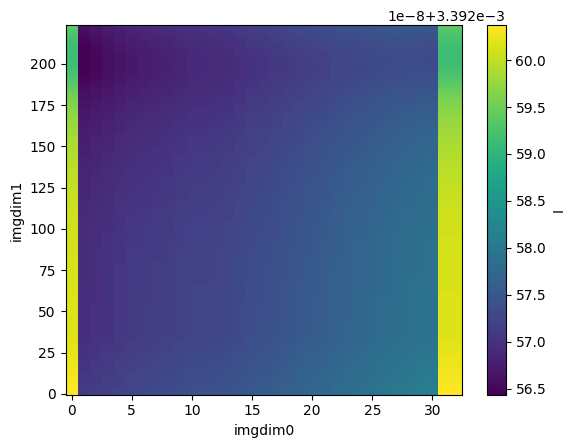

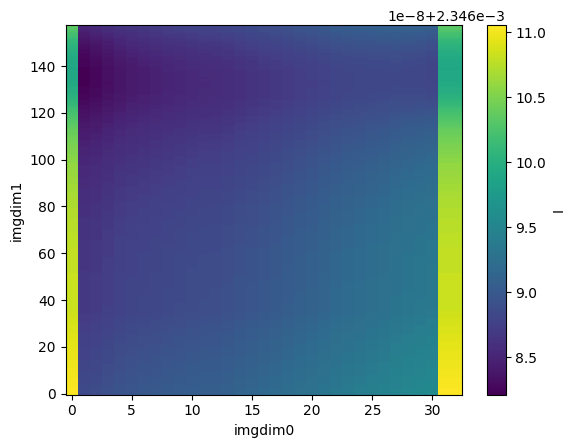

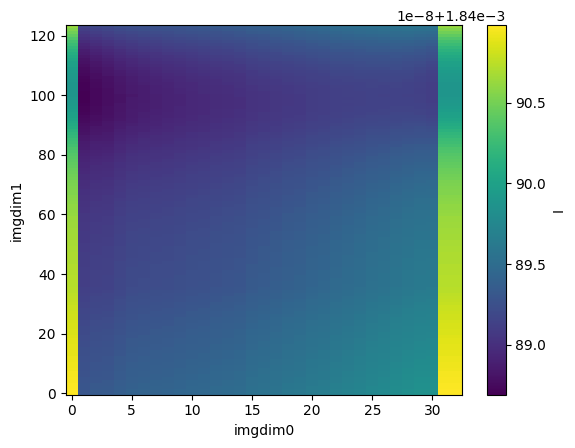

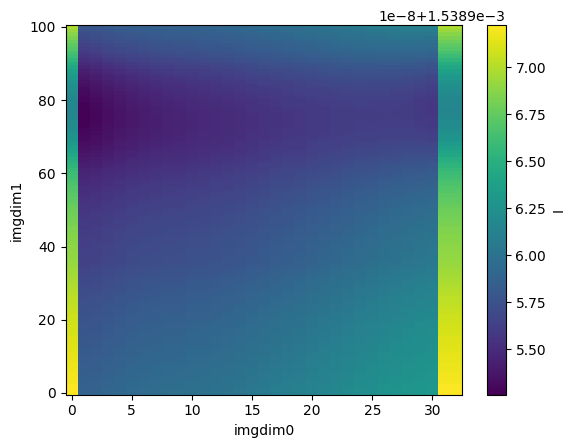

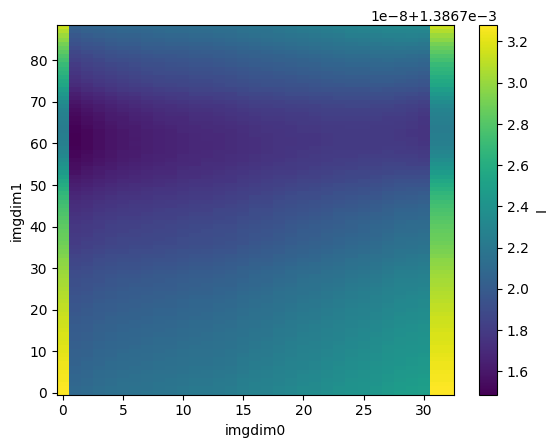

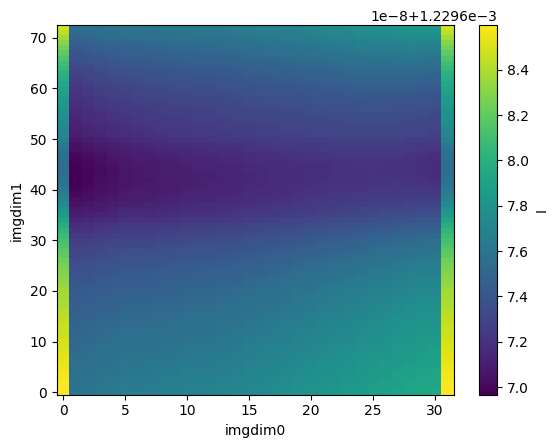

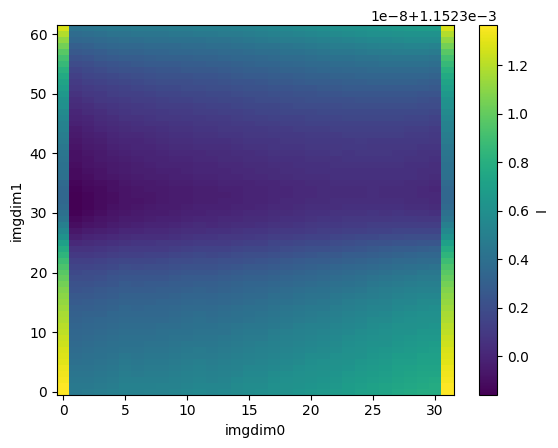

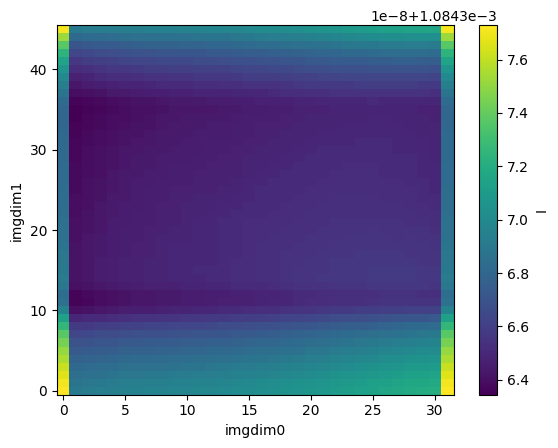

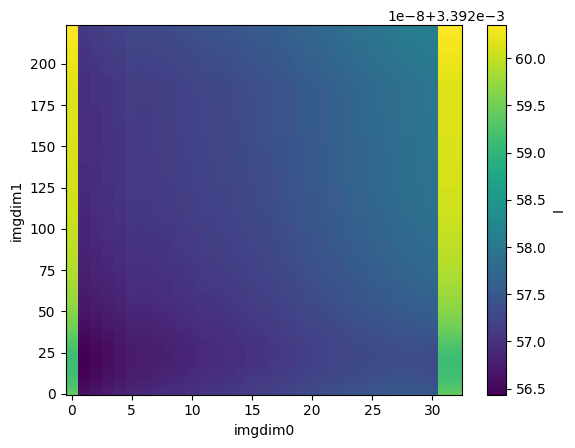

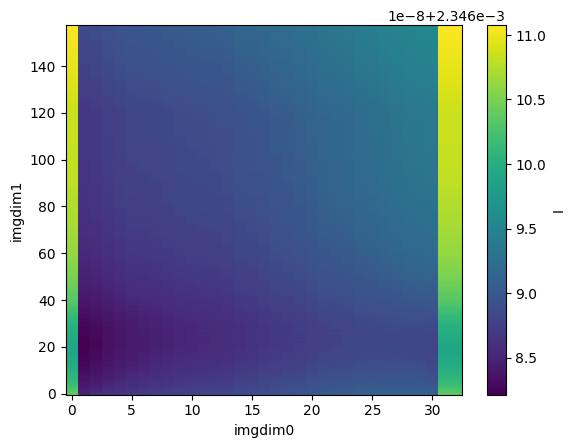

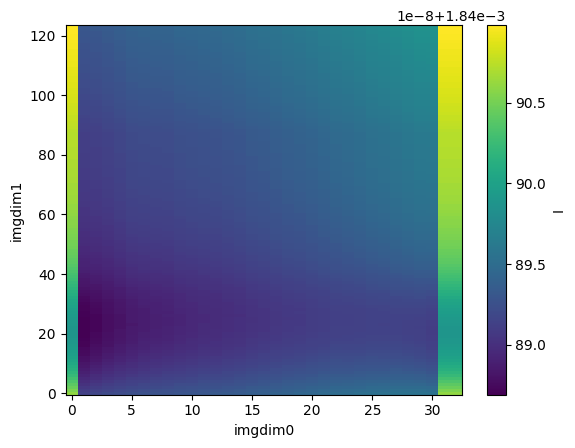

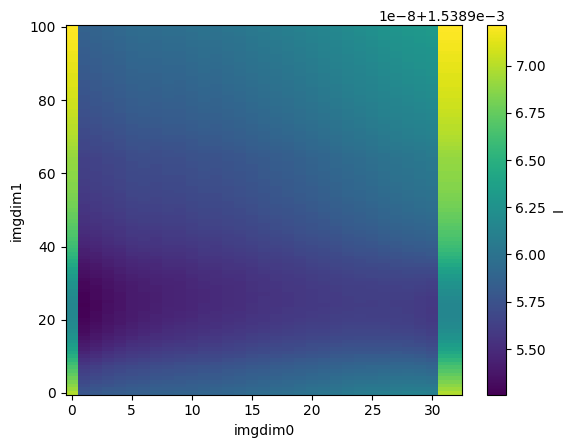

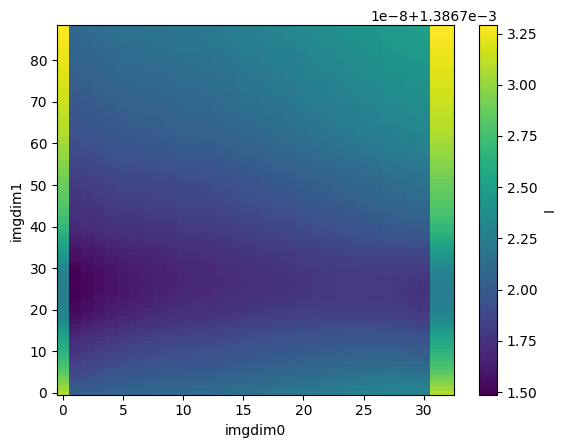

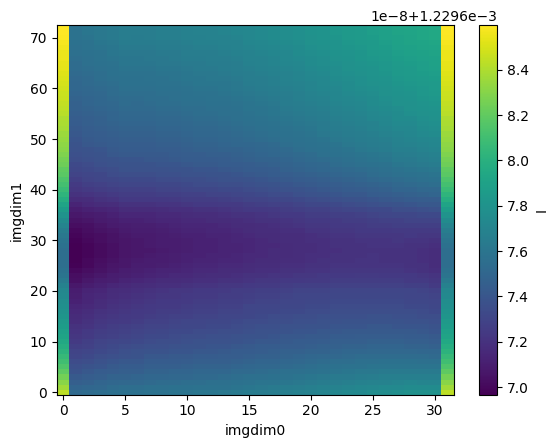

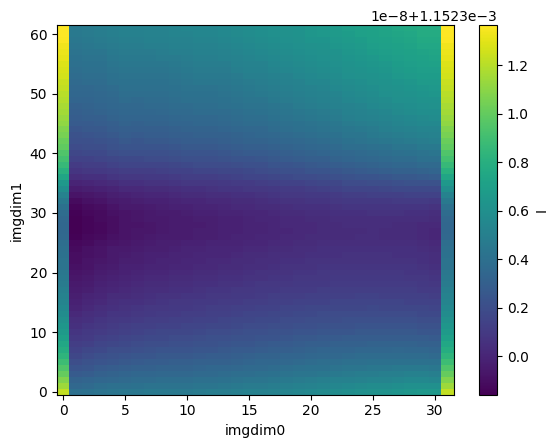

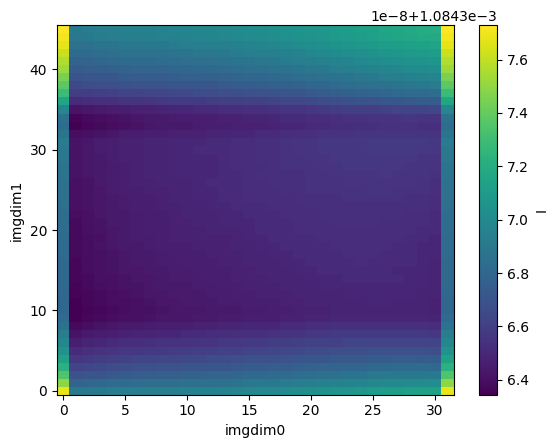

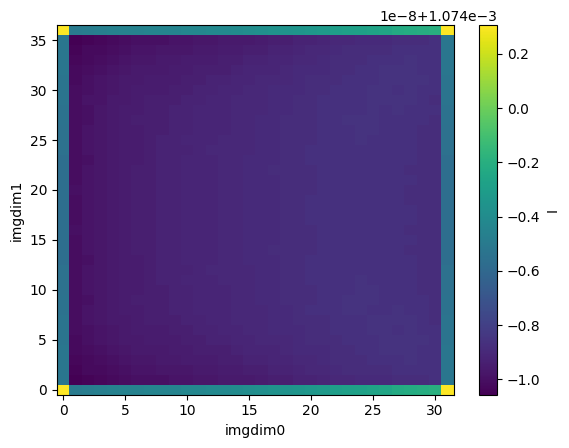

In [13]:
state_gen(x0)
#visualize the initial state
forward_sensors.get_measurements(solvers_reconstruct)

for instrument in forward_sensors:
    for im in forward_sensors.get_images(instrument):
        py.figure()
        im.I.T.plot()

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.238  0.149E-04    31968     9.00  0.035   [Radiance 0.660 micron]
     2  -4.100  0.150E-04    31968     9.00  0.035   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        28377     M =           10

At X0     28350 variables are exactly at the bounds

At iterate    0    f=  2.15961D+02    |proj g|=  7.63406D+00
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.306  0.303E-01    31968   228.05  0.891   [Radiance 0.660 micron]
     2  -2.647  0.298E-01    31968   228.05  0.891   [Radiance 0.660 micron]
     3  -4.375  0.298E-01    31968   228.05  0.891   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000042   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1

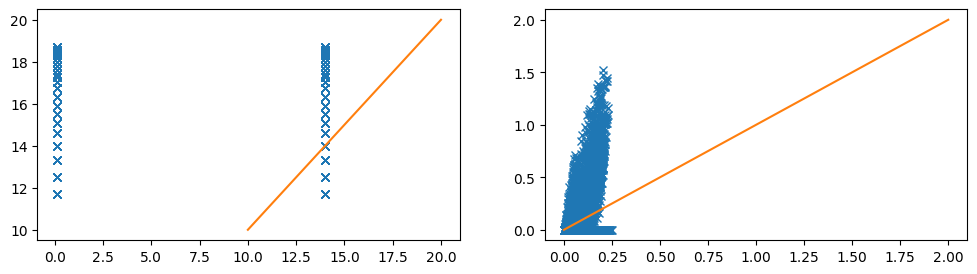

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.748  0.100E-01    31968   225.16  0.880   [Radiance 0.660 micron]
     2  -3.655  0.983E-02    31968   225.16  0.880   [Radiance 0.660 micron]
     3  -5.901  0.983E-02    31968   225.16  0.880   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000001   [Radiance 0.660 micron]

At iterate    2    f=  5.16993D+01    |proj g|=  4.96814D+00
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.748  0.100E-01    31968   225.16  0.880   [Radiance 0.660 micron]
     2  -3.655  0.983E-02    31968   225.16  0.880   [Radiance 0.660 micron]
     3  -5.901  0.983E-02    31968   225.16  0.880   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000001   [Radiance 0.660 micron]
-0.0709986032410076
0.38072352236019474
-0.08902354943174459
0.6231887543191826


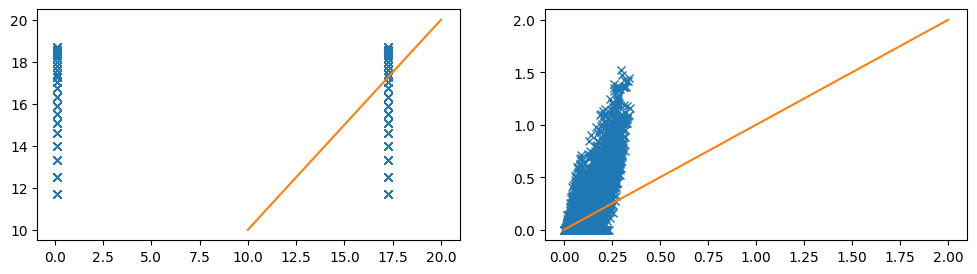


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28377      2      5    318     0   316   4.968D+00   5.170D+01
  F =   51.699278238790669     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [14]:
import warnings
optimizer = at3d.optimize.Optimizer(objective_function,callback_fn=callback, options={'maxiter': 100, 'maxls': 10, 'disp': True})
warnings.filterwarnings('ignore')
optimizer._options['maxiter'] = 2
result = optimizer.minimize(x0)

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.748  0.100E-01    31968   225.16  0.880   [Radiance 0.660 micron]
     2  -3.655  0.983E-02    31968   225.16  0.880   [Radiance 0.660 micron]
     3  -5.901  0.983E-02    31968   225.16  0.880   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000001   [Radiance 0.660 micron]
-0.0709986032410076
0.38072352236019474
-0.08902354943174459
0.6231887543191826


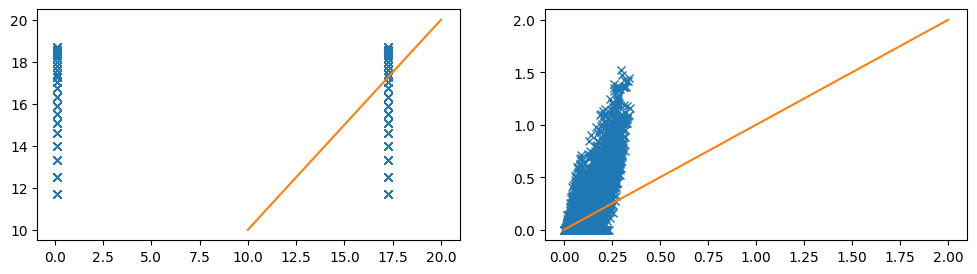

{'None': None}

In [15]:
plot(optimizer)

In [16]:
print(solvers_reconstruct)

SolversDict([(0.66, <at3d.solver.RTE object at 0x7fe0e9fc2920>)])


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.748  0.100E-01    31968   225.16  0.880   [Radiance 0.660 micron]
     2  -3.655  0.983E-02    31968   225.16  0.880   [Radiance 0.660 micron]
     3  -5.901  0.983E-02    31968   225.16  0.880   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000001   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        28377     M =           10

At X0       373 variables are exactly at the bounds

At iterate    0    f=  5.16993D+01    |proj g|=  4.96814D+00
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.635  0.317E-02    31968   209.27  0.817   [Radiance 0.660 micron]
     2  -3.422  0.312E-02    31968   209.27  0.817   [Radiance 0.660 micron]
     3  -5.365  0.312E-02    31968   209.27  0.817   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000004   [Radiance 0.660 micron]

At

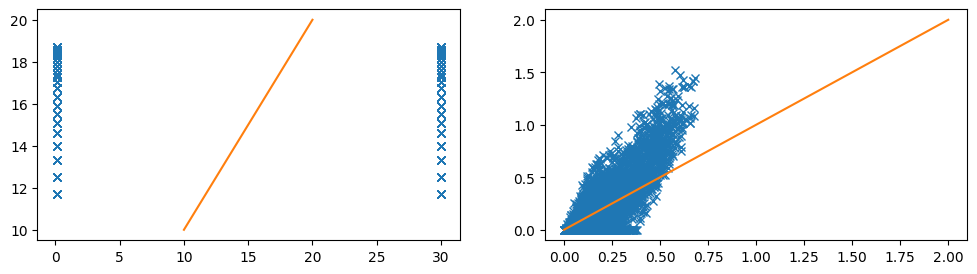

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.568  0.734E-02    31968   209.08  0.817   [Radiance 0.660 micron]
     2  -3.284  0.705E-02    31968   209.08  0.817   [Radiance 0.660 micron]
     3  -5.124  0.705E-02    31968   209.08  0.817   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000008   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.613  0.448E-02    31968   212.67  0.831   [Radiance 0.660 micron]
     2  -3.376  0.432E-02    31968   212.67  0.831   [Radiance 0.660 micron]
     3  -5.284  0.432E-02    31968   212.67  0.831   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000005   [Radiance 0.660 micron]

At iterate    2    f=  2.65978D+01    |proj g|=  1.15897D+00
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.613  0.448E-02    31968   212.67  0.831   [Radiance 0.660 micron]
     2  -3.376  0.4

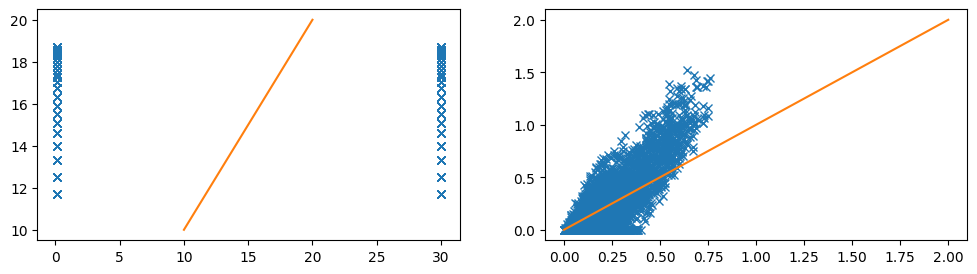

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.556  0.736E-02    31968   200.24  0.782   [Radiance 0.660 micron]
     2  -3.268  0.705E-02    31968   200.24  0.782   [Radiance 0.660 micron]
     3  -5.061  0.705E-02    31968   200.24  0.782   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000009   [Radiance 0.660 micron]

At iterate    3    f=  2.24295D+01    |proj g|=  5.87251D-01
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.556  0.736E-02    31968   200.24  0.782   [Radiance 0.660 micron]
     2  -3.268  0.705E-02    31968   200.24  0.782   [Radiance 0.660 micron]
     3  -5.061  0.705E-02    31968   200.24  0.782   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000009   [Radiance 0.660 micron]
0.081411525849947
0.1568557671121637
0.08143426985952927
0.3840658908208755


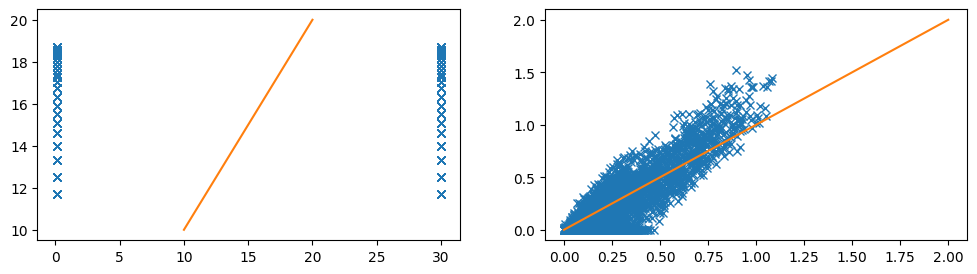

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.543  0.641E-02    31968   189.09  0.739   [Radiance 0.660 micron]
     2  -3.257  0.611E-02    31968   189.09  0.739   [Radiance 0.660 micron]
     3  -5.008  0.611E-02    31968   189.09  0.739   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]

At iterate    4    f=  1.61472D+01    |proj g|=  4.33957D-01
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.543  0.641E-02    31968   189.09  0.739   [Radiance 0.660 micron]
     2  -3.257  0.611E-02    31968   189.09  0.739   [Radiance 0.660 micron]
     3  -5.008  0.611E-02    31968   189.09  0.739   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]
0.04588915766963011
0.13515205669284994
0.03146917513119609
0.3688277829109231


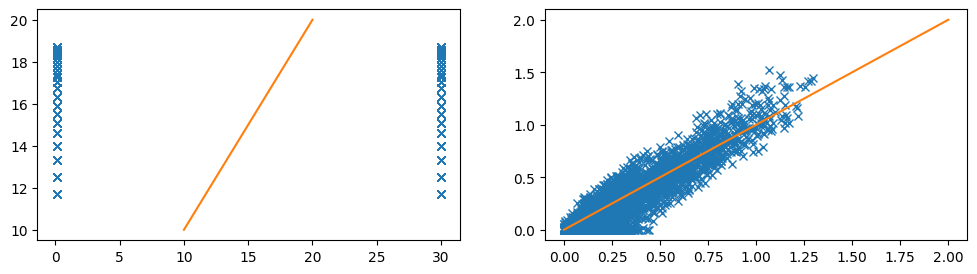

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.536  0.707E-02    31968   185.70  0.725   [Radiance 0.660 micron]
     2  -3.254  0.711E-02    31968   185.70  0.725   [Radiance 0.660 micron]
     3  -4.992  0.711E-02    31968   185.70  0.725   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]

At iterate    5    f=  1.36105D+01    |proj g|=  2.94396D-01
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.536  0.707E-02    31968   185.70  0.725   [Radiance 0.660 micron]
     2  -3.254  0.711E-02    31968   185.70  0.725   [Radiance 0.660 micron]
     3  -4.992  0.711E-02    31968   185.70  0.725   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]
0.03204341224933203
0.1245387630642137
0.025957754523844218
0.3692531455227268


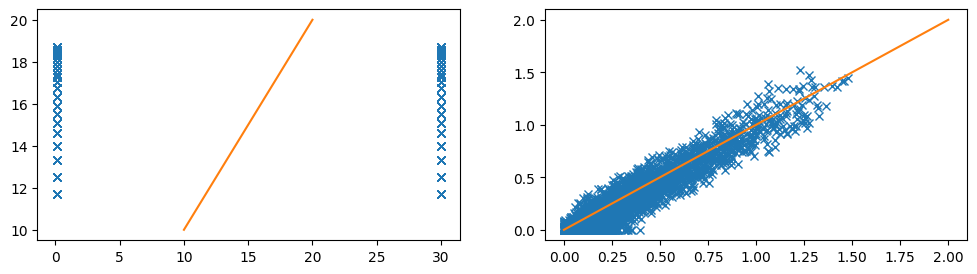

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.531  0.874E-02    31968   179.11  0.700   [Radiance 0.660 micron]
     2  -3.249  0.879E-02    31968   179.11  0.700   [Radiance 0.660 micron]
     3  -4.987  0.879E-02    31968   179.11  0.700   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]

At iterate    6    f=  1.30889D+01    |proj g|=  2.65629D-01
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.531  0.874E-02    31968   179.11  0.700   [Radiance 0.660 micron]
     2  -3.249  0.879E-02    31968   179.11  0.700   [Radiance 0.660 micron]
     3  -4.987  0.879E-02    31968   179.11  0.700   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]
0.03129110851611624
0.12600176753553471
0.01608263033423384
0.3691411031266452


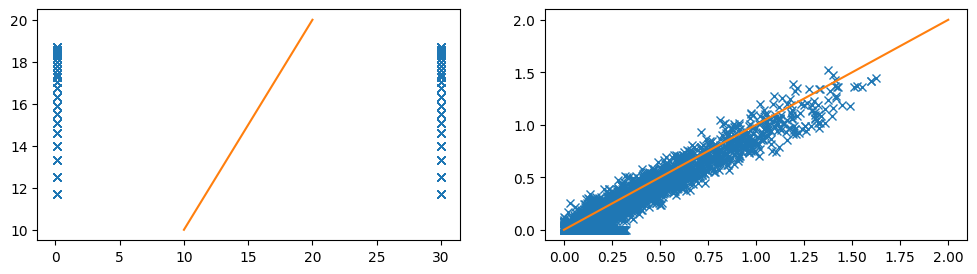

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.527  0.994E-02    31968   181.56  0.709   [Radiance 0.660 micron]
     2  -3.247  0.100E-01    31968   181.56  0.709   [Radiance 0.660 micron]
     3  -4.988  0.100E-01    31968   181.56  0.709   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.530  0.904E-02    31968   195.09  0.762   [Radiance 0.660 micron]
     2  -3.249  0.910E-02    31968   195.09  0.762   [Radiance 0.660 micron]
     3  -4.987  0.909E-02    31968   195.09  0.762   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.531  0.881E-02    31968   195.09  0.762   [Radiance 0.660 micron]
     2  -3.249  0.886E-02    31968   195.09  0.762   [Radiance 0.660 micron]
    

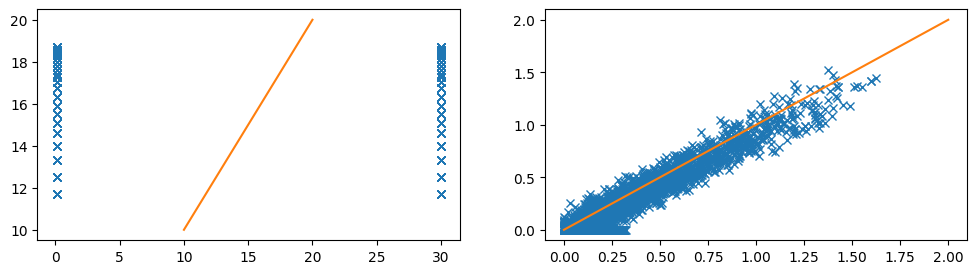

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.530  0.943E-02    31968   194.96  0.762   [Radiance 0.660 micron]
     2  -3.249  0.949E-02    31968   194.96  0.762   [Radiance 0.660 micron]
     3  -4.988  0.949E-02    31968   194.96  0.762   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.531  0.891E-02    31968   195.65  0.764   [Radiance 0.660 micron]
     2  -3.249  0.896E-02    31968   195.65  0.764   [Radiance 0.660 micron]
     3  -4.987  0.896E-02    31968   195.65  0.764   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.531  0.879E-02    31968   195.65  0.764   [Radiance 0.660 micron]
     2  -3.249  0.884E-02    31968   195.65  0.764   [Radiance 0.660 micron]
    


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.533  0.887E-02    31968   192.63  0.752   [Radiance 0.660 micron]
     2  -3.252  0.892E-02    31968   192.63  0.752   [Radiance 0.660 micron]
     3  -4.992  0.892E-02    31968   192.63  0.752   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]

At iterate    8    f=  1.25570D+01    |proj g|=  2.01856D-01
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.533  0.887E-02    31968   192.63  0.752   [Radiance 0.660 micron]
     2  -3.252  0.892E-02    31968   192.63  0.752   [Radiance 0.660 micron]
     3  -4.992  0.892E-02    31968   192.63  0.752   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]
0.025241322579274895
0.12315112662091932
0.02046846157556849
0.3670302968203248


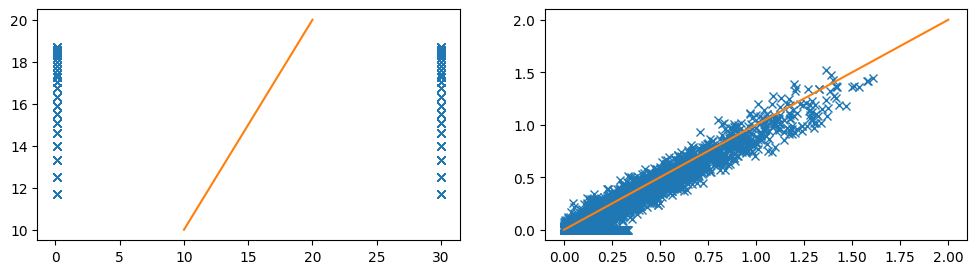

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.534  0.901E-02    31968   194.63  0.760   [Radiance 0.660 micron]
     2  -3.254  0.907E-02    31968   194.63  0.760   [Radiance 0.660 micron]
     3  -4.996  0.907E-02    31968   194.63  0.760   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]

At iterate    9    f=  1.23832D+01    |proj g|=  2.98561D-01
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.534  0.901E-02    31968   194.63  0.760   [Radiance 0.660 micron]
     2  -3.254  0.907E-02    31968   194.63  0.760   [Radiance 0.660 micron]
     3  -4.996  0.907E-02    31968   194.63  0.760   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]
0.025768833820203903
0.12568348468349658
0.018176098013533603
0.3663419583691706


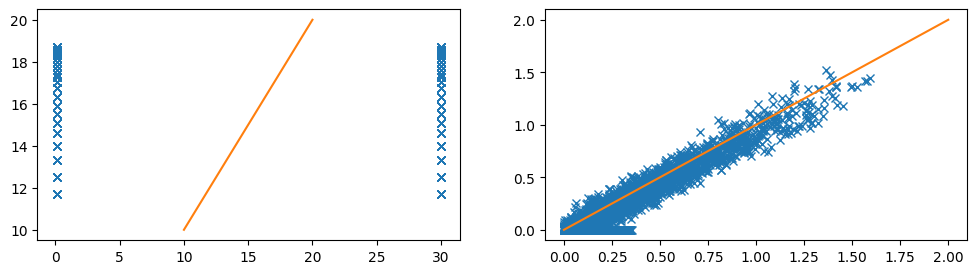

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.532  0.987E-02    31968   176.54  0.690   [Radiance 0.660 micron]
     2  -3.250  0.992E-02    31968   176.54  0.690   [Radiance 0.660 micron]
     3  -5.006  0.992E-02    31968   176.54  0.690   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.535  0.927E-02    31968   197.41  0.771   [Radiance 0.660 micron]
     2  -3.254  0.932E-02    31968   197.41  0.771   [Radiance 0.660 micron]
     3  -5.001  0.932E-02    31968   197.41  0.771   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.534  0.907E-02    31968   197.41  0.771   [Radiance 0.660 micron]
     2  -3.254  0.912E-02    31968   197.41  0.771   [Radiance 0.660 micron]
    


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.533  0.914E-02    31968   192.82  0.753   [Radiance 0.660 micron]
     2  -3.252  0.919E-02    31968   192.82  0.753   [Radiance 0.660 micron]
     3  -4.995  0.919E-02    31968   192.82  0.753   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.534  0.905E-02    31968   198.24  0.774   [Radiance 0.660 micron]
     2  -3.253  0.910E-02    31968   198.24  0.774   [Radiance 0.660 micron]
     3  -4.996  0.910E-02    31968   198.24  0.774   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.534  0.902E-02    31968   198.24  0.774   [Radiance 0.660 micron]
     2  -3.254  0.907E-02    31968   198.24  0.774   [Radiance 0.660 micron]
    

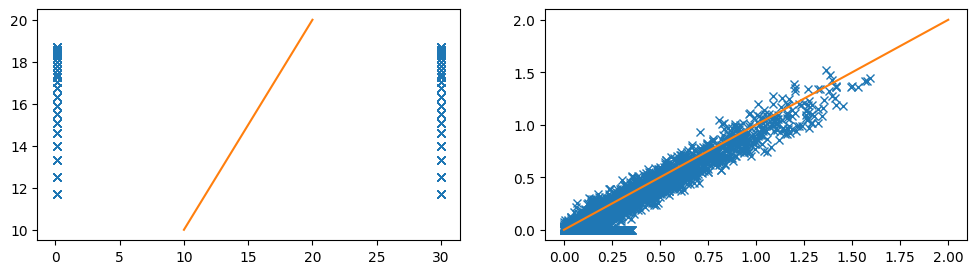


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28377     10     42   8878     0  4586   3.074D-01   1.237D+01
  F =   12.372884746765511     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [17]:
final_state = state_gen.get_state()
import warnings
warnings.filterwarnings('ignore')
optimizer._options['maxiter'] = 10
result = optimizer.minimize(final_state)

In [18]:
unknown_scatterer_indices = list(solvers_reconstruct.values())[0]._unknown_scatterer_indices - 1
unknown_scatterer_names = np.array(list(list(solvers_reconstruct.values())[0].medium.keys()))[unknown_scatterer_indices]
print(unknown_scatterer_names)
#print(objective_function(state_gen.get_state())[0].shape)
grads = (objective_function(state_gen.get_state())[1])

['cloud' 'cloud']
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -1.534  0.904E-02    31968   198.24  0.774   [Radiance 0.660 micron]
     2  -3.253  0.909E-02    31968   198.24  0.774   [Radiance 0.660 micron]
     3  -4.996  0.909E-02    31968   198.24  0.774   [Radiance 0.660 micron]
 ! Iterations:      3     Final Criterion:  0.000010   [Radiance 0.660 micron]


In [19]:
print(list(grads[:38500]))
print(x0.shape)

[-6.176731666944267, -6.176731664261403, -6.176737481819906, -6.176735071838497, -6.176734227459523, -6.176735035393158, -6.176737315316333, -6.176739657588576, -6.176740940526565, -6.176740466325939, -6.176738537797561, -6.176737446191763, -6.17673747742857, -6.176738193418787, -6.176739393521022, -6.17674007433299, -6.1767408934912185, -6.176740954855422, -6.176739398520079, -6.176738311662059, -6.176738136408308, -6.176739330813637, -6.176740651563807, -6.17673886131331, -6.176736311239098, -6.17673507046941, -6.176752002194558, 0.33240810011689176, 0.7311464638000782, -0.011863228774828833, 0.0021965905660785864, 0.008360491673423906, 0.008907946925330415, 0.006853177957110599, 0.00021944194567725446, -0.0024150333717805244, -0.0022396475163545403, 0.003571016854210963, 0.005258955456191849, 0.005766836493788271, 0.0034033544691688556, 0.0036827136250954643, 0.003887930489821248, 0.003696953571085713, 0.001455310229210317, -0.0003604234530773547, 0.0058595523168064895, 0.0034362798

In [20]:
# loss, gradient, _ = at3d.gradient.LevisApproxGradientUncorrelated(
            # sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
            # gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
            # uncertainty_kwargs={'add_noise': False})()
# print(gradient["gradient"][:,:,:,0].std())
# print(gradient["gradient"][:,:,:,0].mean())
# print(gradient["gradient"][:,:,:,0].max())
# print(gradient["gradient"][:,:,:,0].min())

# print(gradient["gradient"][:,:,:,1].std())
# print(gradient["gradient"][:,:,:,1].mean())
# print(gradient["gradient"][:,:,:,1].max())
# print(gradient["gradient"][:,:,:,1].min())

In [21]:
# plot(optimizer)
# print(solvers[.66].medium['cloud'].density)
# print(initial_1d_density.shape)
# print(initial_gridded_density.shape)
# print(ray_mask_pixel.shape)
print(carved_volume.mask.data[carved_volume.mask.data == 0].shape)
print(list(x0[26:]))
print(initial_gridded_reff)
print(state_gen._unknown_scatterers['cloud'].variables['reff'].state_to_grid.inverse_transform(initial_gridded_reff))

(3618,)
[-2.2708229783478235, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0.25637747365960734, -0

In [22]:
# plot(optimizer)
print(solvers_reconstruct[.66].medium['cloud'].density.shape)

(32, 37, 27)


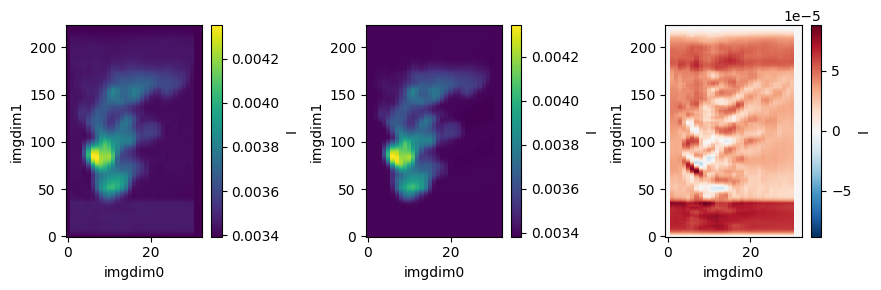

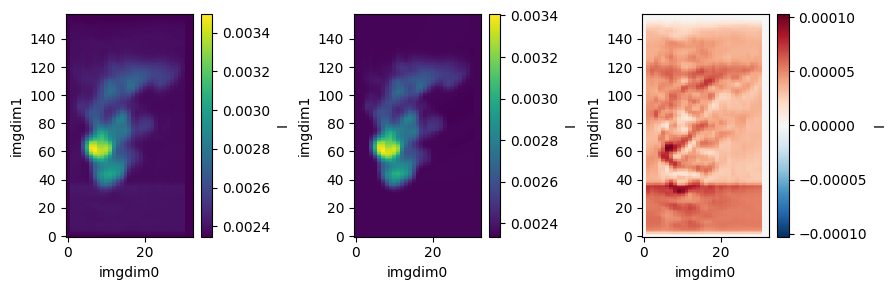

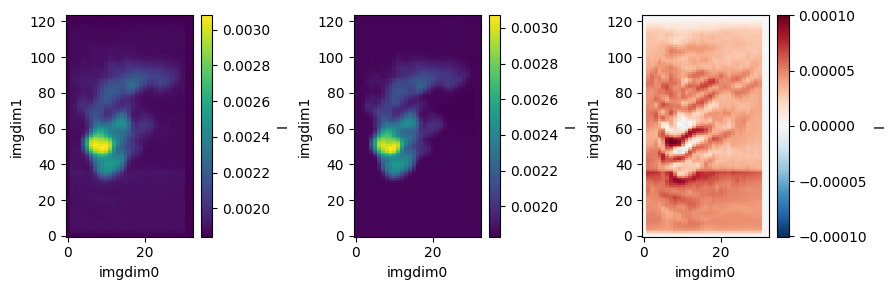

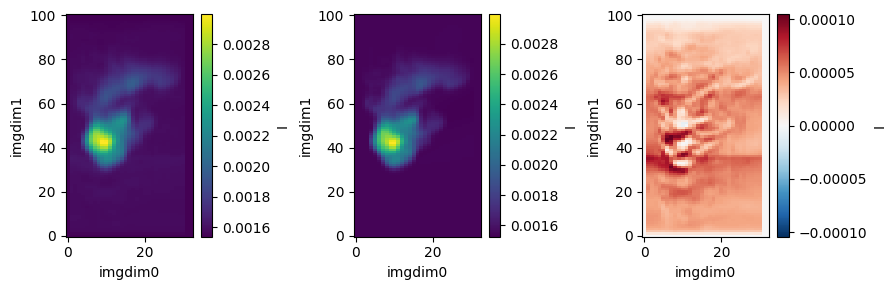

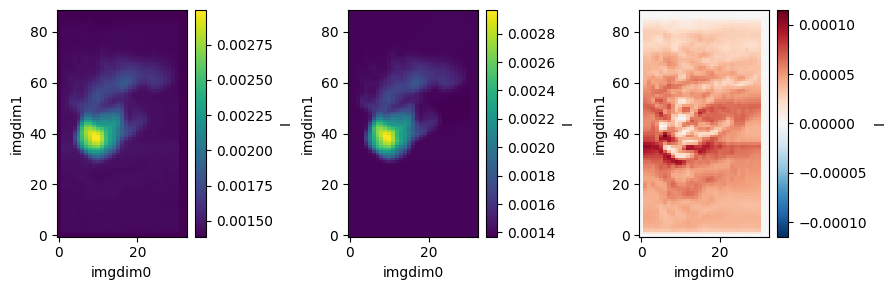

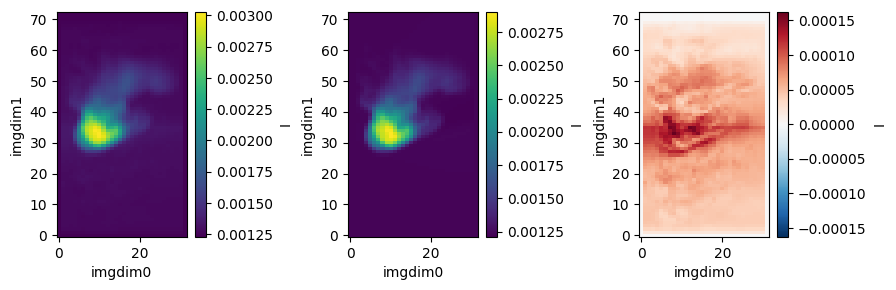

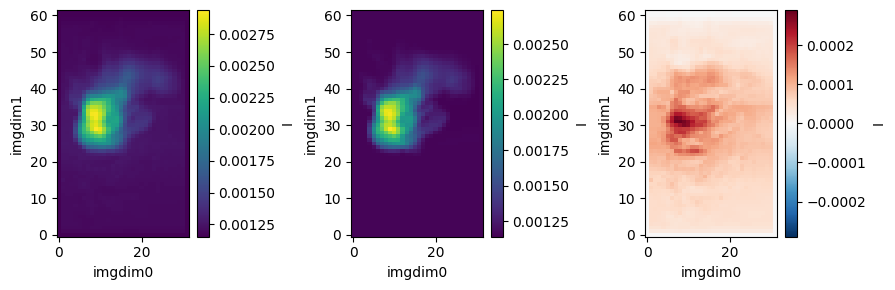

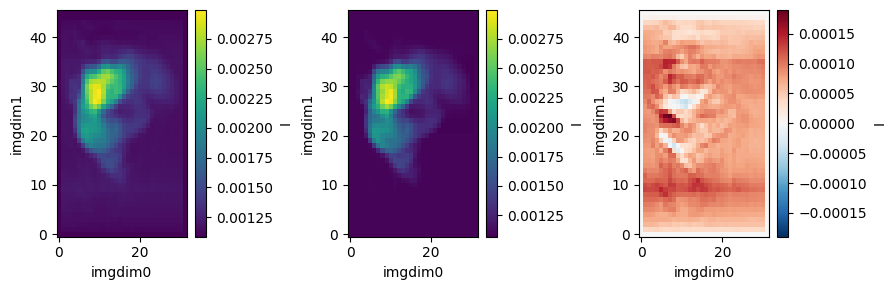

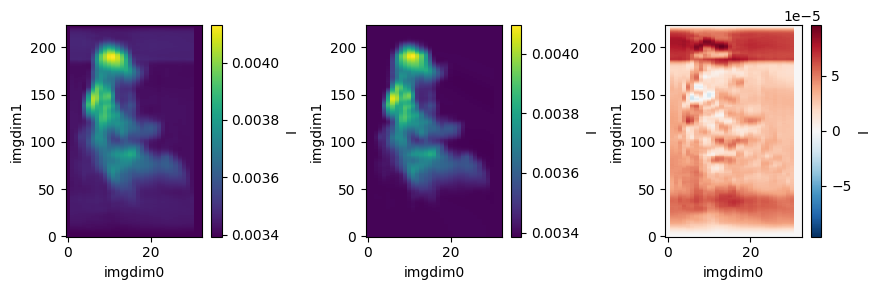

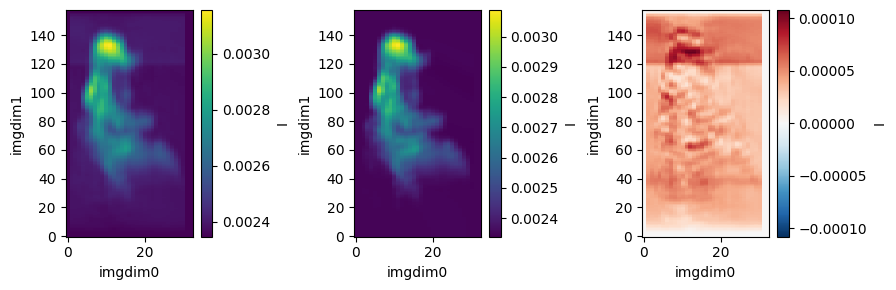

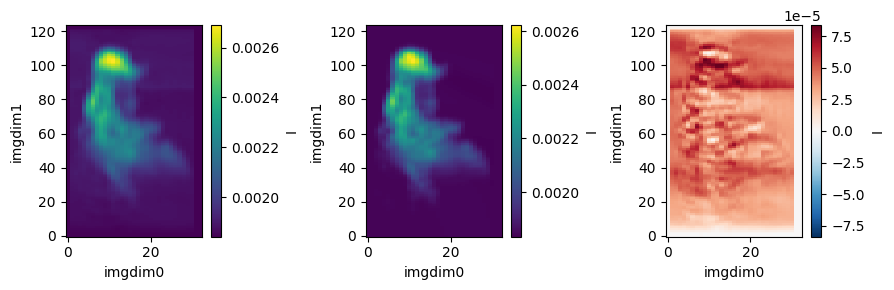

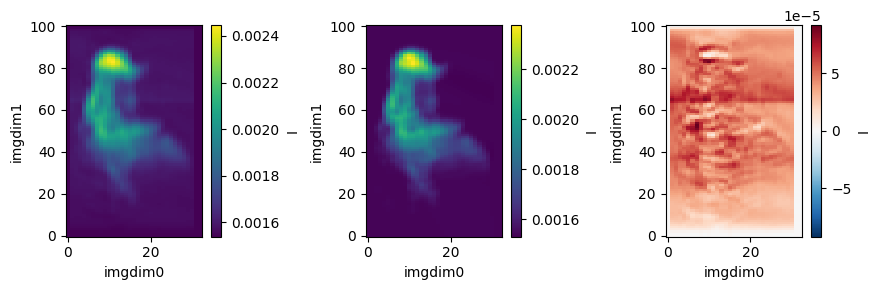

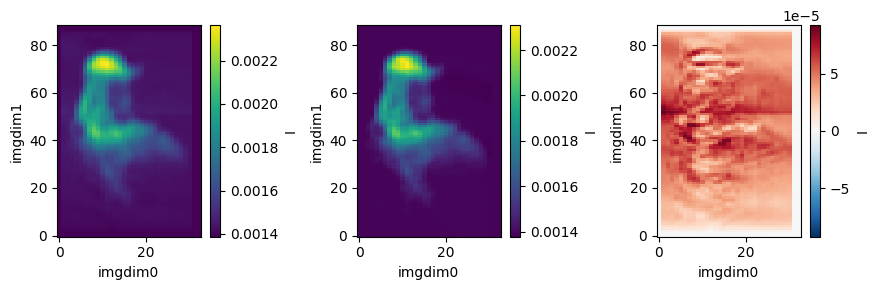

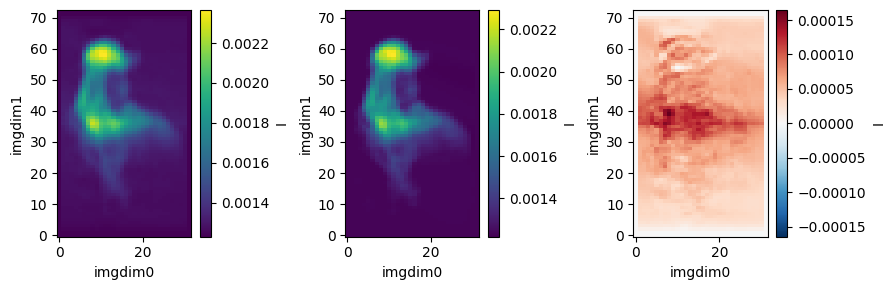

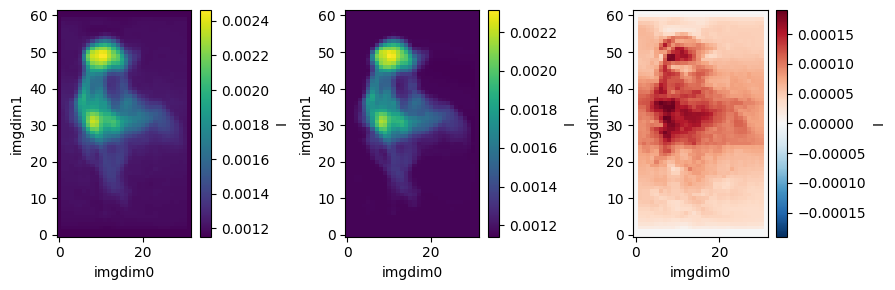

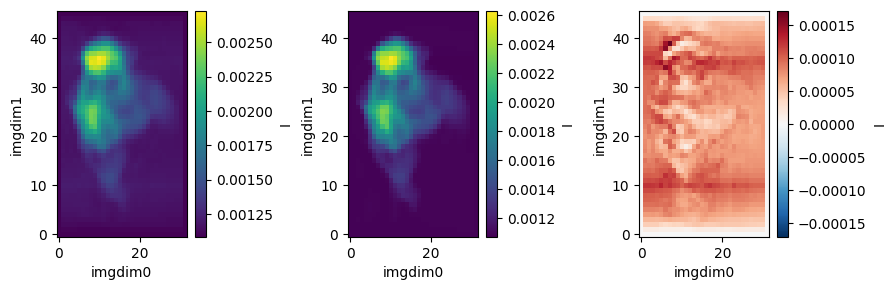

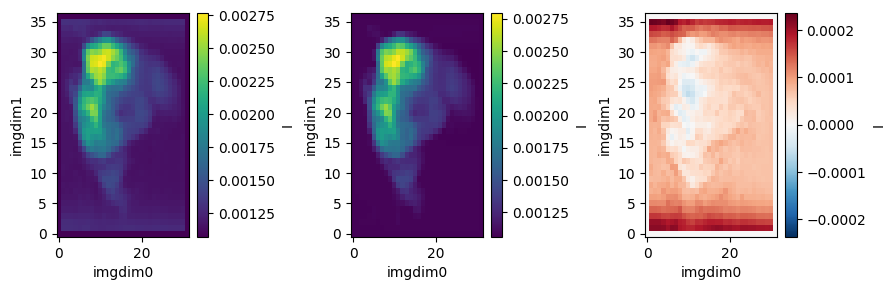

In [23]:
for instrument in forward_sensors:
    for im1,im2 in zip(forward_sensors.get_images(instrument),
                       sensors.get_images(instrument)):
        fig,ax = py.subplots(1,3, figsize=(9, 3))
        im1.I.T.plot(ax=ax[0])
        im2.I.T.plot(ax=ax[1])
        (im1.I-im2.I).T.plot(ax=ax[2])
        fig.tight_layout()